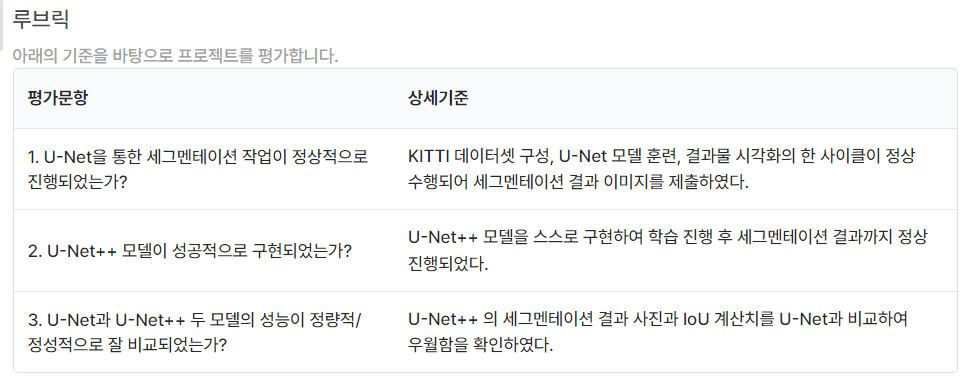

$ pip list | grep albumentations

데이터 로더 입력값 출력값 둘다 224, 224

augmentation - albumentation 적용하자

학습셋의 일정량을 검증 데이터셋으로 활용할수 있도록 해야한다.



In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

Albumentation에서 다양한 <b>augmentation 기법을 확률적으로 적용</b>할 수 있게 해주는 Compose()의 활용예입니다. 
    
imgaug의 Sometimes()와 유사한 기능입니다.

# Compose를 통해 다양한 augmentation을 train에 적용한다

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [3]:
def build_augmentation(is_train=True):
    if is_train: # 훈련용 데이터만 플립, 랜덤사이즈크롭 적용
        return Compose([
            HorizontalFlip(p=0.5), 
            RandomSizedCrop(
                min_max_height=(300,370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224,
            )
        ])
    return Compose([ #Resize는 공통적용
        Resize(
            width=224,
            height=224
        )
        
    ])
        

augmentation을 train과 test에 각각 적용한 후, glob을 통해 파일 디렉토리 내의 png 파일을 가져온다

그 후 plt로 시각화를 한다 



[[[ 12  12  13]
  [ 12  12  14]
  [ 11  14  14]
  ...
  [241 255 255]
  [239 255 255]
  [234 255 255]]

 [[ 12  13  12]
  [ 12  13  14]
  [ 11  13  14]
  ...
  [240 255 255]
  [236 255 255]
  [230 255 255]]

 [[  9  12  12]
  [  9  12  14]
  [ 10  12  14]
  ...
  [240 255 255]
  [237 255 255]
  [235 255 255]]

 ...

 [[ 93 106 122]
  [ 88 106 112]
  [ 94 104 107]
  ...
  [103 102 105]
  [ 98 102 106]
  [ 96 104 105]]

 [[ 83  99 113]
  [ 83  98 119]
  [ 96 105 123]
  ...
  [104 100 100]
  [ 99  99 101]
  [ 94 100 101]]

 [[113 110 111]
  [117 112 121]
  [115 122 122]
  ...
  [ 95 100 100]
  [ 96  99 100]
  [ 97  99  99]]]
[[[ 29  33  27]
  [ 29  35  38]
  [ 33  40  39]
  ...
  [101 156 227]
  [100 157 225]
  [ 99 157 225]]

 [[ 29  38  29]
  [ 28  40  29]
  [ 32  38  29]
  ...
  [104 158 227]
  [102 159 226]
  [ 99 159 226]]

 [[ 32  41  29]
  [ 32  40  28]
  [ 32  36  26]
  ...
  [103 157 228]
  [102 159 227]
  [ 99 159 227]]

 ...

 [[100 103  88]
  [103 102  96]
  [109 106 100]
  ..

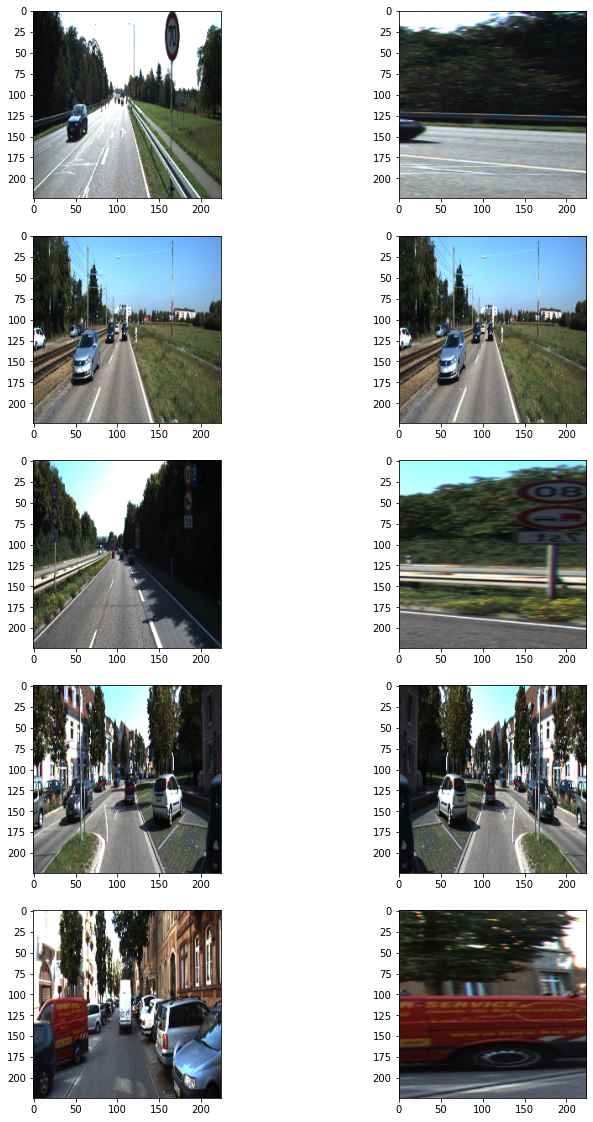

In [15]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(False)    
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

#훈련 데이터셋에서 5개만 가져와서 어그멘테이션 적용하자
plt.figure(figsize=(12,20))

for i in range(5):
    image = imread(input_images[i])
    print(image)
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5,2,2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5,2,2*i+2)
    plt.imshow(processed["image"])

plt.show()





**image_data 를 쓰는건 몇개 들어올지 모르나 여러개 파라미터를 넘겨준다는 뜻이다
https://scikit-image.org/docs/stable/api/skimage.io.html

skimage.io.imread(fname[, as_gray, plugin])

Load an image from file.

args ? kwargs ? 이거보면 해결 -> arguments와  keyward arguments다. 즉 is_true=True 이런식으로 선언해야되는 부분은 kwargs로 분류되는것

https://jhproject.tistory.com/109

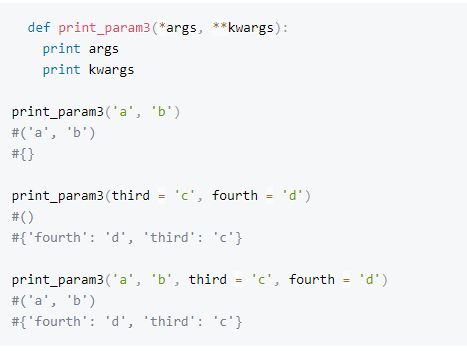


In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                dir_path,
                 batch_size=16,
                 img_size=(224,224,3),
                 output_size=(224,224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        #load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join())
        
        